In [1]:
import pandas as pd
import os 
from pathlib import Path
from bertopic import BERTopic
import re 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns



condition = "Dreamachine"
remove_stopwords = True
extended_stopwords = True

metaproject_name = 'TopicModelling_META'
subproject_name = 'TopMod_pipeline'
dataset_name = f'{condition}_dataset.csv'


PROJDIR = os.path.expanduser(f"~/projects/{metaproject_name}")
DATADIR = os.path.join(PROJDIR,f'DATA/{dataset_name}')
CODEDIR = os.path.join(PROJDIR,f'{subproject_name}')

reports = pd.read_csv(DATADIR,usecols=['text']).dropna()
reports.head()


%matplotlib inline

/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/rb666/projects/TopicModelling_META/topmodvenv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/rb666/projects/TopicModelli

In [2]:
# Remove punctuation
def process_text(x):
    if isinstance(x, str):  # check if x is of type string
        x = re.sub('[,\.!?;]', '', x)  # if it is, do the replacement
        x = re.sub('^[0-9]+', '', x)  # remove initial numbers
        return x.lower()
    else:
        return ""  # otherwise, return an empty string or you can convert it to string by using `return str(x)`

reports['text_processed'] = reports['text'].map(process_text)

# Convert the titles to lowercase
reports['text_processed'] = reports['text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
print(reports['text_processed'].head())

print('N = {} reports'.format(len(reports)))

0    the colours made patterns when i had my eyes c...
1    intense chaos and then my mind checked out and...
2                                       good stuff\r\n
3    a pattern of red and white lights thatflashed ...
4    i wentback to many hard and mostly beautiful m...
Name: text_processed, dtype: object
N = 377 reports


In [3]:

stop_words = stopwords.words('english')
# print(len(stop_words))

extended_stopwords_list = ['dreamachine','machine','end','felt','experience','like','first','anxiety']
if extended_stopwords:
    stop_words.extend(extended_stopwords_list)
    print('Removing extended list of stopwords (N = {} extended stopwords) ...'.format(len(extended_stopwords_list)))

reports['text_without_stopwords'] = reports['text_processed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

if remove_stopwords:
    print('Removing stopwords (N={} stopwords) ...'.format(len(stop_words)))
    reports['text_processed'] = reports['text_without_stopwords']

Removing extended list of stopwords (N = 8 extended stopwords) ...
Removing stopwords (N=187 stopwords) ...


count    377.000000
mean      11.021220
std       10.453777
min        1.000000
25%        4.000000
50%        8.000000
75%       15.000000
max       67.000000
Name: report_length, dtype: float64
The mean report length is 11 words.
The longest report has 67 words.


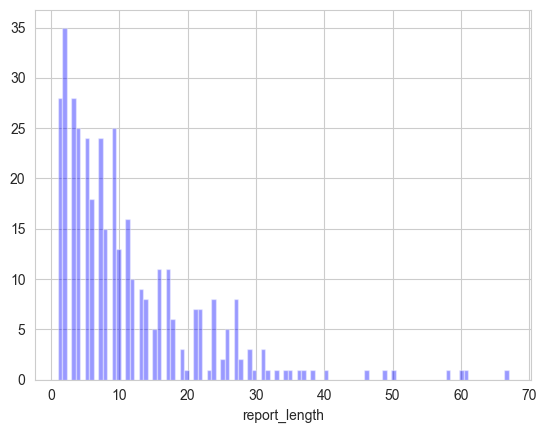

In [4]:
reports["report_length"] = reports["text_processed"].apply(lambda x: len(x.split(" ")))   # count words in each report

#Visualize the distribution of report lengths
sns.set_style('whitegrid')
# get_ipython().run_line_magic('matplotlib', 'inline')
sns.distplot(reports['report_length'], kde=False, color='blue', bins=100)

print(reports['report_length'].describe())
print("The mean report length is {} words.".format(round(reports['report_length'].mean())))
print("The longest report has {} words.".format(max(reports['report_length'])))

## BERTopic

https://miro.medium.com/v2/resize:fit:4800/format:webp/0*DxAqCqx6dzg0KQlg.png

### Training the BERT model

In [5]:
from bertopic import BERTopic

model = BERTopic(language="english", calculate_probabilities=True, verbose=True,embedding_model="all-MiniLM-L6-v2",min_topic_size=11) #The higher the value of min_topic_size, the more specific the topics will be
topics, probs = model.fit_transform(reports['text_processed']) #Fit model to data : topics are the topic labels for each document, probs are the probabilities of each topic for each document
model.visualize_topics() #Visualize topics

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

2023-08-11 11:43:02,482 - BERTopic - Transformed documents to Embeddings
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-08-11 11:43:05,437 - BERTopic - Reduced dimensionality
2023-08-11 11:43:05,447 - BERTopic - Clustered reduced embeddings


### Topic extraction and representation

In [6]:
topic_freq = model.get_topic_freq().head() #Get the frequency of each topic
freq = model.get_topic_info() #Get the frequency of each topic
print("N number of topics: ",len(freq))
print(freq.head())


N number of topics:  6
   Topic  Count                                Name  \
0     -1    138         -1_time_body_sense_memories   
1      0    138          0_saw_colours_shapes_space   
2      1     34  1_relaxed_relaxing_joy_interesting   
3      2     28        2_music_mind_sounds_relaxing   
4      3     26      3_thoughts_people_mind_thought   

                                      Representation  \
0  [time, body, sense, memories, really, would, s...   
1  [saw, colours, shapes, space, moving, one, pat...   
2  [relaxed, relaxing, joy, interesting, want, st...   
3  [music, mind, sounds, relaxing, thinking, sens...   
4  [thoughts, people, mind, thought, brain, walki...   

                                 Representative_Docs  
0  [many different things little afraid thinking ...  
1  [thought universe moving moving centre drawn s...  
2  [experienced calmness almost nothingness relax...  
3  [saw stars hexagons tesselating twisting zoomi...  
4  [brain massaged sometimes overw

In [7]:
model.get_topic(0) #Get the most frequent words of the first topic (the words and their probabilities, ie TF-IDF scores)

[('saw', 0.051689045314747335),
 ('colours', 0.045949843823709244),
 ('shapes', 0.03731710544228835),
 ('space', 0.03558309800556501),
 ('moving', 0.03501202259055195),
 ('one', 0.03202478820500851),
 ('patterns', 0.030950810621959462),
 ('light', 0.028791455171180196),
 ('eyes', 0.02835123326107979),
 ('point', 0.026420228378591513)]

## Prileminary visualisation

In [8]:
model.visualize_barchart(top_n_topics=10) #Visualize the top 10 topics

In [9]:
model.visualize_documents(reports['text_processed'])

In [10]:
model.visualize_heatmap(top_n_topics=10) #Visualize the top 10 topics as a heatmap

In [11]:
model.visualize_topics() #Visualize topics (similar to LDA visualization representation)

In [12]:
model.visualize_hierarchy(top_n_topics=10)

### Get the top 3 topics

In [13]:
similarities = model.find_topics("lsd") #Find topics similar to the word "lsd"
similarities

([-1, 1, 2, 3, 0], [0.44750866, 0.3828647, 0.38214612, 0.34018758, 0.27900034])

In [14]:
# Select the 3 most similar topics
similar_topics, similarity = model.find_topics("hallucination", top_n=3) #Find the 5 most similar topics to the word "lsd"
print(similar_topics) #Print the 3 most similar topics : index from the most similar to the least similar


most_similar_topics = similar_topics[0] #Get the most similar topic
print(most_similar_topics) #Print the most similar topic
print("Similarity score: ", similarity[0]) #Print the similarity score
print("Most similar topic: ", model.get_topic(most_similar_topics)) #Print the most similar topic

[3, -1, 0]
3
Similarity score:  0.5025221
Most similar topic:  [('thoughts', 0.1312435711185524), ('people', 0.06788802441174367), ('mind', 0.05302374970516008), ('thought', 0.052262885646389194), ('brain', 0.049082474101367936), ('walking', 0.047163533541325665), ('towards', 0.04306340414746881), ('made', 0.03681185557602595), ('things', 0.03681185557602595), ('though', 0.03599787979279282)]


In [15]:
# %%bash
# mkdir -p ~/projects/TopicModelling_META/TopMod_pipeline/BERT_outputs

In [16]:


# BERT_model_name = f"BERT_model_{condition}"
# model.save(os.path.join("BERT_outputs",BERT_model_name)) #Save model

# BERT_model = BERTopic.load(BERT_model_name)
# BERT_model